## **0. data setting**

링크 : https://www.kaggle.com/frogsohyun/bookingcom-hotel-review

데이터 : booking.com hotel reviews

구성 : 총 35668개의 리뷰

기타 : 1) 리뷰 별 좋았던 점, 아쉬웠던 점이 구분되어 있음 2) 결측치, 중복 없음

In [ ]:
# Import package
%%capture
import sys

if 'google.colab' in sys.modules:
    !sudo apt-get install -y fonts-nanum 
    !sudo fc-cache -fv
    !rm ~/.cache/matplotlib -rf
    !pip install konlpy
    !pip install squarify
    !pip install git+https://github.com/haven-jeon/PyKoSpacing.git
    !pip install git+https://github.com/ssut/py-hanspell.git
    !pip install gensim

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import re
import numpy as np
import gensim

from gensim.models import Word2Vec
from tqdm.notebook import tqdm
from collections import Counter
from konlpy.tag import Okt
from hanspell import spell_checker
from pykospacing import Spacing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Import data
url = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/booking.com_hotel_review.csv'

df = pd.read_csv(url)
df.head()
# 원본 데이터에는 아래와 같이 전처리가 완료된 Column(cleaned_review)이 존재하나
# 전처리는 직접 하는 것이 프로젝트 의미에 부합하고, 개인 역량 향상에도 도움 된다고 판단되어 해당 Column을 Drop하고 진행하였습니다

,Unnamed: 0,hotel_name,hotel_review,cleaned_review
0,0,호텔 힐튼부산,좋았던 점\n · 한적한분위기\n야외풀 서비스 모두 훌륭합니다\n아쉬웠던 점\n ·...,한적하다 분위기 야외 서비스 훌륭하다 식당 부족하다 저렴하다 식사 필요
1,1,호텔 힐튼부산,좋았던 점\n · 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 :)\n아쉬...,친절하다 깨끗하다 바다 보이다 욕조 딱하다
2,2,호텔 힐튼부산,좋았던 점\n · 발코니 너무 좋았어요..\n아쉬웠던 점\n · 샤워실이 이곳저곳이...,발코니 샤워실 낙후 조식 먹다 사람 일회용 장갑 사람 끼다 정확하다 전달
3,3,호텔 힐튼부산,좋았던 점\n · 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다.\n...,아침식사 생각 다양하다 메뉴 구성 되어다 후기 비다 만족스럽다 크다 기대 방문 그렇...
4,4,호텔 힐튼부산,좋았던 점\n · 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다.\n아쉬...,아침 일찍 바다 커피한잔 말다 날씨 영향 가다 덥다


In [ ]:
# 불필요한 Column Drop
df.drop(columns='cleaned_review', inplace=True)

# 열 이름 변경 및 id 값 보정
df = df.rename(columns={'Unnamed: 0':'id'})
df['id'] += 1

# 결과 확인
df.head()

,id,hotel_name,hotel_review
0,1,호텔 힐튼부산,좋았던 점\n · 한적한분위기\n야외풀 서비스 모두 훌륭합니다\n아쉬웠던 점\n ·...
1,2,호텔 힐튼부산,좋았던 점\n · 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 :)\n아쉬...
2,3,호텔 힐튼부산,좋았던 점\n · 발코니 너무 좋았어요..\n아쉬웠던 점\n · 샤워실이 이곳저곳이...
3,4,호텔 힐튼부산,좋았던 점\n · 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다.\n...
4,5,호텔 힐튼부산,좋았던 점\n · 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다.\n아쉬...


## **1. Pre-processing, EDA**

### **1-0. 배경지식 정리**

리조트는 휴양지라는 뜻으로 레저시설이나 놀이시설을 갖춘 전체적인 숙박시설을 말한다.

리조트라는 포괄적인 범위 안에서 숙박시설이 취사가 가능하면 콘도. 취사가 가능하지 않으면 호텔이라고 부른다.

따로 호텔만 있을 경우 호텔 내부에 편의 시설과 부대시설을 갖는다.

In [ ]:
# 데이터 크기 확인
df.shape

(36669, 3)

In [ ]:
# 결측치 확인
df.isnull().sum()

id              0
hotel_name      0
hotel_review    0
dtype: int64

In [ ]:
# hotel_name data 확인
df_name = pd.DataFrame(df['hotel_name'].value_counts())
df_name = df_name.rename(columns={'hotel_name':'counts'})

# value_counts 결과를 df로 변환 후 index의 특정 구간 별로 결괏값을 확인
df_name.iloc[29:40,:]

,counts
호텔 둔산 그레이톤 호텔,135
호텔 오크우드 프리미어 인천,133
호텔 롯데 리조트 속초,133
호텔 제주 노블레스 관광호텔,130
호텔 글래드 마포,130
리조트 켄싱턴 리조트 가평 (구 청평점),130
호텔 더 파크 호텔 서울,130
더 큐브 리조트 제주,130
호텔 중문시티호텔,130
호텔 글래드 여의도,130


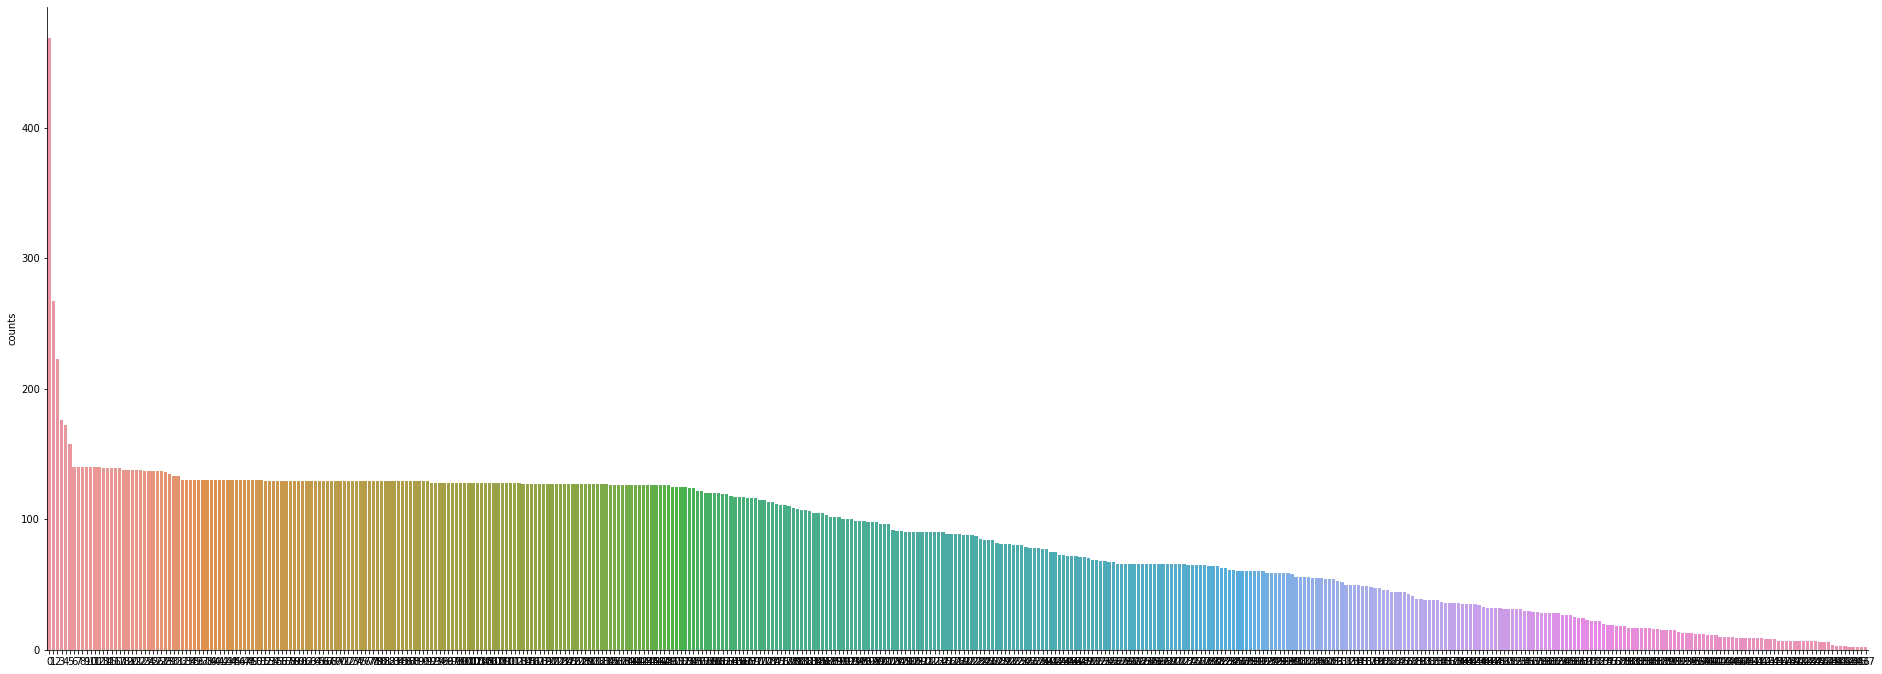

In [ ]:
# index reset
df_name = df_name.reset_index()
df_name.head()

# value_counts() 분포 확인
myplot = sns.catplot(x=df_name.index, y="counts", kind="bar", data=df_name);
myplot.fig.set_size_inches(30,10)

### **1-1. hotel_name column 작업 진행사항**

1. Text 중간에 \n, &, -, , 가 포함되어 있는 경우 있음 -> 해당 Text는 space로 대체 (이후 정규표현식으로 한글, 영문, 띄어쓰기만 선택)
2. Text 중간에 space가 여러 개 포함되어 있는 경우 있음 -> 해당 Text는 space 한 칸으로 대체
3. 리뷰가 10개 이하인 시설이 있음 -> 분석 목적에 따라 제외하거나 선택하는 등의 유동적인 활용을 진행

In [ ]:
# 전처리 진행
df['hotel_name_tok'] = df['hotel_name']

# 기본 전처리
text_desc = []
for text in df['hotel_name_tok'] :
  # replace 디테일하게 할 필요는 없지만 혹시 몰라서 사전 제거 후 정규 표현식 적용
    text = text.replace('\n', ' ').strip()
    doc_tokens = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣]", " ", str(text))
    doc_tokens = doc_tokens.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ').replace('     ', ' ')
    doc_tokens = doc_tokens.lower()
    text_desc.append(doc_tokens)

df.loc[:]['hotel_name_tok'] = text_desc

In [ ]:
# 결과 확인
df_name_pre = pd.DataFrame(df['hotel_name_tok'].value_counts())
df_name_pre = df_name_pre.rename(columns={'hotel_name_tok':'counts'})

df_name_pre.iloc[29:40,:]

,counts
호텔 둔산 그레이톤 호텔,135
호텔 오크우드 프리미어 인천,133
호텔 롯데 리조트 속초,133
더 큐브 리조트 제주,130
호텔 더 파크 호텔 서울,130
호텔 글래드 마포,130
호텔 스타즈 호텔 독산,130
호텔 베스트웨스턴 프리미어 강남 호텔,130
호텔 코모도 호텔 부산,130
호텔 체이슨 호텔 더 스마일,130


### **1-2. hotel_review column 작업 진행사항**

1. 이전 column과 마찬가지로 기본 전처리 필요
2. 리뷰의 형식이 좋았던 점 + 아쉬웠던 점의 형식으로 설정되어 있음 -> 각각 column을 분리하여 저장

  (전체 리뷰 / 좋았던 점 / 아쉬웠던 점 총 3개의 column 도출)

In [ ]:
# 전처리 진행 (이전 column과 동일한 방식으로)
df['hotel_review_tok'] = df['hotel_review']

# 기본 전처리
text_desc = []
for text in df['hotel_review_tok'] :
    text = text.replace('\n · ', ' ').replace('\n', ' ').replace('좋았던 점', '좋았던점').replace('아쉬웠던 점', '아쉬웠던점').strip()
    doc_tokens = re.sub(r"[^a-zA-Z0-9ㄱ-ㅣ가-힣]", " ", str(text))
    doc_tokens = doc_tokens.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ').replace('     ', ' ')
    doc_tokens = doc_tokens.lower()
    text_desc.append(doc_tokens)

df.loc[:]['hotel_review_tok'] = text_desc

# 결과 확인
df.head()

,id,hotel_name,hotel_review,hotel_name_tok,hotel_review_tok
0,1,호텔 힐튼부산,좋았던 점\n · 한적한분위기\n야외풀 서비스 모두 훌륭합니다\n아쉬웠던 점\n ·...,호텔 힐튼부산,좋았던점 한적한분위기 야외풀 서비스 모두 훌륭합니다 아쉬웠던점 식당이 부족해요 저렴...
1,2,호텔 힐튼부산,좋았던 점\n · 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 :)\n아쉬...,호텔 힐튼부산,좋았던점 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 아쉬웠던점 딱히 없습니다
2,3,호텔 힐튼부산,좋았던 점\n · 발코니 너무 좋았어요..\n아쉬웠던 점\n · 샤워실이 이곳저곳이...,호텔 힐튼부산,좋았던점 발코니 너무 좋았어요 아쉬웠던점 샤워실이 이곳저곳이 낙후가 된것같아요 조...
3,4,호텔 힐튼부산,좋았던 점\n · 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다.\n...,호텔 힐튼부산,좋았던점 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의...
4,5,호텔 힐튼부산,좋았던 점\n · 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다.\n아쉬...,호텔 힐튼부산,좋았던점 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 아쉬웠던점 날씨에...


In [ ]:
# 전처리 진행 - 리뷰 속성 별 column 분리
df['hotel_review_good'] = df['hotel_review_tok']
df['hotel_review_bad'] = df['hotel_review_tok']

review_good = []
review_bad = []

for i in df['hotel_review_tok'] : 
  if i.find('아쉬웠던점') != -1 :
      review_good.append(i.split('아쉬웠던점')[0])
      review_bad.append(i.split('아쉬웠던점')[1])
  else :
      review_good.append(i)
      review_bad.append('작성한 내용이 없습니다')

df.loc[:]['hotel_review_good'] = review_good
df.loc[:]['hotel_review_bad'] = review_bad

# 결과 확인
df.head()

,id,hotel_name,hotel_review,hotel_name_tok,hotel_review_tok,hotel_review_good,hotel_review_bad
0,1,호텔 힐튼부산,좋았던 점\n · 한적한분위기\n야외풀 서비스 모두 훌륭합니다\n아쉬웠던 점\n ·...,호텔 힐튼부산,좋았던점 한적한분위기 야외풀 서비스 모두 훌륭합니다 아쉬웠던점 식당이 부족해요 저렴...,좋았던점 한적한분위기 야외풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳필요
1,2,호텔 힐튼부산,좋았던 점\n · 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 :)\n아쉬...,호텔 힐튼부산,좋았던점 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 아쉬웠던점 딱히 없습니다,좋았던점 친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다,딱히 없습니다
2,3,호텔 힐튼부산,좋았던 점\n · 발코니 너무 좋았어요..\n아쉬웠던 점\n · 샤워실이 이곳저곳이...,호텔 힐튼부산,좋았던점 발코니 너무 좋았어요 아쉬웠던점 샤워실이 이곳저곳이 낙후가 된것같아요 조...,좋았던점 발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은 일회용장갑을 끼고 어...
3,4,호텔 힐튼부산,좋았던 점\n · 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다.\n...,호텔 힐튼부산,좋았던점 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의...,좋았던점 아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 ...
4,5,호텔 힐튼부산,좋았던 점\n · 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다.\n아쉬...,호텔 힐튼부산,좋았던점 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 아쉬웠던점 날씨에...,좋았던점 아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다,날씨에 영향이 많이 가는 곳이더군요


In [ ]:
# 전처리 진행 - "좋았던점"과 같이 굳이 없어도 되는 Text 사전제거 및 공백 보정
review_tok = []
review_good = []
review_bod = []

for x, y, z in zip(df['hotel_review_tok'], df['hotel_review_good'], df['hotel_review_bad']) :
    x = x.replace('좋았던점', '').replace('아쉬웠던점', '').strip()
    x = x.replace('  ', ' ').replace('   ', ' ').replace('    ', ' ').replace('     ', ' ')
    y = y.replace('좋았던점', '').strip()
    z = z.strip()
    review_tok.append(x)
    review_good.append(y)
    review_bod.append(z)

df.loc[:]['hotel_review_tok'] = review_tok
df.loc[:]['hotel_review_good'] = review_good
df.loc[:]['hotel_review_bad'] = review_bod

# 불필요한 column 제거
df.drop(columns=['hotel_name', 'hotel_review'], inplace=True)

# 결과 확인
df.head()

,id,hotel_name_tok,hotel_review_tok,hotel_review_good,hotel_review_bad
0,1,호텔 힐튼부산,한적한분위기 야외풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳필요,한적한분위기 야외풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳필요
1,2,호텔 힐튼부산,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 딱히 없습니다,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다,딱히 없습니다
2,3,호텔 힐튼부산,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은...,발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은 일회용장갑을 끼고 어떤...
3,4,호텔 힐튼부산,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...
4,5,호텔 힐튼부산,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 날씨에 영향이 많이 가는 ...,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다,날씨에 영향이 많이 가는 곳이더군요


## **2. Text Mining**

### **2-0. 한국어 자연어 처리 관련 정리**
- 한국어 자연어 처리 위해 KoNLPy 패키지 사용
- KoNLPy 패키지에서 제공하는 Okt(Open Korea Text) 형태소 분석기 사용

   (형태소를 너무 디테일하게 나눌 필요가 없는 상황이라고 판단되었고, 여러 분석기를 비교 분석해보기엔 시간이 부족하다 판단되어)

### **2-1. Tokenize**
- 불용어 사전은 Raw Data의 Tokenize 및 Counter 결과를 확인하여 불용어로 판단되는 단어를 업데이트 하면서 적용

- Tokenize 적용 간 사용한 패키지 
1. pykospacing : 한국어 띄어쓰기가 되어있지 않은 문장을 띄어쓰기를 한 문장으로 변환해주는 패키지
2. hanspell : 네이버 한글 맞춤법 검사기를 바탕으로 맞춤법 검사를 진행 및 수정하는 패키지


In [ ]:
# 불용어 지정
# 구글 서치를 통해 찾은 Base Stopwords
stop_list = "아 휴 아이구 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 여 얼마간 약간 다소 좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 명 생각 시간 그녀 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓"
stop_list = stop_list.split()

stop_words_name = set(['호텔', '리조트', '더', '스테이', '다', '그랜드', '앤', '파크', '인', '앰', '라', 'hotel', '아파트', '수', '트', '아', '도', '플', 'city', '역', '구',
                       '코', '머', '디', 'l', '7', '움', '온', '츠', '홈', '마', '오', '티', '텔', '비', 'by', '반', '제', '원', '보', '여', '톤', '여관', '청', '2', '타',
                       '1', '엔', '불', '고', '솔', '재', '풀', '샤', '그리', '요', 'b', '케', '니', '신', '몬', 'i', '디', '즈', '에', '포', '소', '르', '하', '촌', '뉴',
                       '엘', '나', '의', '준', '부산', '제주', '서울', '속초', '해운대', '스', '인천', '강남', '동대문', '명동', '거제', '구로', '송도', '인천공항'])

stop_words_review_good = set(stop_list + ['도', '이', '하다', '가', '에', '이다', '을', '들', '은', '는', '에서', '으로', '과', '의', '로', '를', '분들', '다',
                              '와', '적', '되어다', '것', '이라', '곳', '한', '인', '분', '하고', '고', '들다', '등', '또', '1', '까지', '때', '그리고',
                              '점', '2', '싶다', '잘', '더', '에도', '만', '라', '나', '요', '랑', '3', '역', '및', '이나', '개', '여서', '대',
                              '못', '4', 'ㅎㅎ', '내', '기', '서', '그', '면', '류', '게', '님', '맘', '두', '이상', '인데', '저', '제', '시',
                              '쉬', '박', '딱', '번', '중', '5', '일', '날', '움', '명', '전', '쪽', '함', '성', '장', '거', '듯', '해',
                              '엔', '편', '온', '임', '니', '하', '문', '잠', '식', '후', '너무', '좋다', '보다', '아주', '만족하다', '괜찮다', '주다', '방문', '정말', '호텔', '오다', '감사하다'])

stop_words_review_bad = set(stop_list + ['이', '하다', '가', '에', '한', '을', '은', '도', '를', '같다', '에서', '조금', '는', '으로', '이다', '의', '되다', '것', '들', '보다',
                             '안', '로', '점',  '인', '다', '아니다', '더', '되어다', '가다', '만', '못', '과', '이라', '수', '요', '그렇다', '2', '적', '나다', '1', '그리고', '고', '정도',
                             '그', '하고', '곳', '분', '느낌', '나', '받다', '들다', '에는', '등', '와', '부분', 'ㅠ', '까지', '기', '3', '인데', '하나', '라', '내', '서', '이나',
                             '제', '그냥', '듯', 'ㅠ', '매우', '싶다', '인지', '시', '객', '중', '돼다', '저', '엔', '거', '전', '지', '후', '랑', '대', '명', '잘', '성',
                             'ㅜㅜ', 'ㅎㅎ', '어', '위', '구', '건', '번', '외', '및', '아쉽다', '좋다', '먹다', '별로', 'ㅠㅠ', '딱하다', '게', '오다', '들어가다', '쪽', '면', '함'])

stop_words_review_ent = set(stop_list + ['도', '이', '하다', '가', '에', '이다', '을', '들', '은', '는', '에서', '으로', '과', '의', '로', '를', '분들', '다',
                              '와', '적', '되어다', '것', '이라', '곳', '한', '인', '분', '하고', '고', '들다', '등', '또', '1', '까지', '때', '그리고',
                              '점', '2', '싶다', '잘', '더', '에도', '만', '라', '나', '요', '랑', '3', '역', '및', '이나', '개', '여서', '대',
                              '못', '4', 'ㅎㅎ', '내', '기', '서', '그', '면', '류', '게', '님', '맘', '두', '이상', '인데', '저', '제', '시',
                              '쉬', '박', '딱', '번', '중', '5', '일', '날', '움', '명', '전', '쪽', '함', '성', '장', '거', '듯', '해',
                              '엔', '편', '온', '임', '니', '하', '문', '잠', '식', '후',
                              '이', '하다', '가', '에', '한', '을', '은', '도', '를', '같다', '에서', '조금', '는', '으로', '이다', '의', '되다', '것', '들', '보다',
                              '안', '로', '점',  '인', '다', '아니다', '더', '되어다', '가다', '만', '못', '과', '이라', '수', '요', '그렇다', '2', '적', '나다', '1', '그리고', '고', '정도',
                              '그', '하고', '곳', '분', '느낌', '나', '받다', '들다', '에는', '등', '와', '부분', 'ㅠ', '까지', '기', '3', '인데', '하나', '라', '내', '서', '이나',
                              '제', '그냥', '듯', 'ㅠ', '매우', '싶다', '인지', '시', '객', '중', '돼다', '저', '엔', '거', '전', '지', '후', '랑', '대', '명', '잘', '성',
                              'ㅜㅜ', 'ㅎㅎ', '어', '위', '구', '건', '번', '외', '및'])

# column copy (다음 작업을 위해 미리 생성)
df['hotel_name_token'] = df['hotel_name_tok']
df['hotel_review_token'] = df['hotel_review_tok']
df['hotel_review_good_token'] = df['hotel_review_good']
df['hotel_review_bad_token'] = df['hotel_review_bad']

# 변수 선언
okt=Okt()

# Tokenize 함수 설정
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    '''
    # review : 전처리할 텍스트
    # okt : okt (미리 생성후 인자로 받음)
    # remove_stopword : 불용어를 제거할지 여부로 기본값은 False
    # stop_word : 사용자가 직접 입력한 불용어 사전으로 기본값은 비어있는 리스트
    '''
    # 형태소 단위로 분할
    word_review = okt.morphs(review, stem=True)
    if remove_stopwords:
        # 불용어 제거
        word_review = [token for token in word_review if not token in stop_words]
    return word_review

In [ ]:
# 변수 선언
spacing = Spacing()

check_review_1 = []
clean_review_2 = []

# 반복문 적용 - hotel_review_good
for review in tqdm(df['hotel_review_good']) :
    # 띄어쓰기 보정
    review_1 = spacing(review)
    # 맞춤법 보정
    review_2 = spell_checker.check(review_1)
    review_final = review_2.checked
    check_review_1.append(review_final)

# 반복문 적용 - hotel_review_bad
for review in tqdm(df['hotel_review_bad']) :
    # 띄어쓰기 보정
    review_1 = spacing(review)
    # 맞춤법 보정
    review_2 = spell_checker.check(review_1)
    review_final = review_2.checked
    clean_review_2.append(review_final)

df.loc[:]['hotel_review_good'] = check_review_1
df.loc[:]['hotel_review_bad'] = clean_review_2
df.head()

  0%|          | 0/36669 [00:00<?, ?it/s]

  0%|          | 0/36669 [00:00<?, ?it/s]

,id,hotel_name_tok,hotel_review_tok,hotel_review_good,hotel_review_bad,hotel_name_token,hotel_review_token,hotel_review_good_token,hotel_review_bad_token
0,1,호텔 힐튼부산,한적한분위기 야외풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳필요,한적한 분위기 야외 풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳 필요,호텔 힐튼부산,한적한분위기 야외풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳필요,한적한분위기 야외풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳필요
1,2,호텔 힐튼부산,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 딱히 없습니다,친절했고 깨끗했으며 바다가 보이는 욕조 뷰가 좋았습니다,딱히 없습니다,호텔 힐튼부산,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 딱히 없습니다,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다,딱히 없습니다
2,3,호텔 힐튼부산,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은...,발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된 것 같아요 조식 먹을 때 어떤 사람은 일회용 장갑을 ...,호텔 힐튼부산,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은...,발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은 일회용장갑을 끼고 어떤...
3,4,호텔 힐튼부산,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,호텔 힐튼부산,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...,아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만...
4,5,호텔 힐튼부산,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 날씨에 영향이 많이 가는 ...,아침 일찍 바다를 보며 커피 한 잔 마실 수 있어 좋았습니다,날씨에 영향이 많이 가는 곳이 더군요,호텔 힐튼부산,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다 날씨에 영향이 많이 가는 ...,아침 일찍 바다를 보며 커피한잔 마실 수 있어 좋았습니다,날씨에 영향이 많이 가는 곳이더군요


In [ ]:
# 파일 중간 저장
df.to_csv("/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df.csv", header=True, index=False)

In [ ]:
# 파일 다시 불러오기
url = '/content/drive/MyDrive/Colab Notebooks/Study/Codestate_AI/Session4/Session4_Project/df.csv'
df = pd.read_csv(url)

# hotel_review_tok column 수정
# 맞춤법 및 띄어쓰기 검사를 진행한 'hotel_review_good', 'hotel_review_bad' column을 더함
df['hotel_review_tok'] = df['hotel_review_good'] + ' ' + df['hotel_review_bad']

# 결과 확인
df.head(3)

,id,hotel_name_tok,hotel_review_tok,hotel_review_good,hotel_review_bad,hotel_name_token,hotel_review_token,hotel_review_good_token,hotel_review_bad_token
0,1,호텔 힐튼부산,한적한 분위기 야외 풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳 필요,한적한 분위기 야외 풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳 필요,호텔 힐튼부산,한적한분위기 야외풀 서비스 모두 훌륭합니다 식당이 부족해요 저렴하게 식사할 곳필요,한적한분위기 야외풀 서비스 모두 훌륭합니다,식당이 부족해요 저렴하게 식사할 곳필요
1,2,호텔 힐튼부산,친절했고 깨끗했으며 바다가 보이는 욕조 뷰가 좋았습니다 딱히 없습니다,친절했고 깨끗했으며 바다가 보이는 욕조 뷰가 좋았습니다,딱히 없습니다,호텔 힐튼부산,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다 딱히 없습니다,친절했고 깨끗했으며 바다가 보이는 욕조뷰가 좋았습니다,딱히 없습니다
2,3,호텔 힐튼부산,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된 것 같아요 조식 먹을 때 어떤 ...,발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된 것 같아요 조식 먹을 때 어떤 사람은 일회용 장갑을 ...,호텔 힐튼부산,발코니 너무 좋았어요 샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은...,발코니 너무 좋았어요,샤워실이 이곳저곳이 낙후가 된것같아요 조식먹을 때 어떤사람은 일회용장갑을 끼고 어떤...


In [ ]:
# 빈 리스트 생성
clean_review_1 = []
clean_review_2 = []
clean_review_3 = []
clean_review_4 = []

# 불용어 제거
# 함수 적용 - hotel_name
for review in df['hotel_name_tok'] :
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에만 진행
    if type(review) == str :
        clean_review_1.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_name))
    else:
        # string이 아니면 비어있는 값 추가
        clean_review_1.append([])

# 함수 적용 - hotel_review_entire
for review in df['hotel_review_tok'] :
    if type(review) == str :
        clean_review_2.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_review_ent))
    else:
        clean_review_2.append([])

# 함수 적용 - hotel_review_good
for review in df['hotel_review_good'] :
    if type(review) == str :
        clean_review_3.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_review_good))
    else:
        clean_review_3.append([])

# 함수 적용 - hotel_review_bad
for review in df['hotel_review_bad'] :
    if type(review) == str :
        clean_review_4.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words_review_bad))
    else:
        clean_review_4.append([])

# 결과 적용
df.loc[:]['hotel_name_token'] = clean_review_1
df.loc[:]['hotel_review_token'] = clean_review_2
df.loc[:]['hotel_review_good_token'] = clean_review_3
df.loc[:]['hotel_review_bad_token'] = clean_review_4

### **2-2. Word counts 확인**

In [ ]:
# 결과 분석 - 함수 생성
def word_count(docs):
    word_counts = Counter()
    word_in_docs = Counter()
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()
    wc['percent'] = wc['count'].apply(lambda x: x / total)
    wc = wc.sort_values(by='rank')
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# 결과 분석 - 함수 적용
wc_1 = word_count(df['hotel_name_token'])
wc_2 = word_count(df['hotel_review_token'])
wc_3 = word_count(df['hotel_review_good_token'])
wc_4 = word_count(df['hotel_review_bad_token'])

In [ ]:
# 결과 확인
wc_1.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
11,라마,1364,1364,1.0,0.018219,0.018219,0.037198
10,바이,1235,1235,2.0,0.016496,0.034714,0.033680
34,프리미어,1074,1074,3.0,0.014345,0.049060,0.029289
17,레지던스,1038,1038,4.0,0.013864,0.062924,0.028307
192,신라,1029,1029,5.0,0.013744,0.076668,0.028062
70,메리어트,882,882,6.0,0.011781,0.088449,0.024053
130,켄싱턴,854,854,7.0,0.011407,0.099856,0.023289
68,배서,779,779,8.0,0.010405,0.110261,0.021244
4,베스트,778,778,9.0,0.010392,0.120652,0.021217
41,시티,719,719,10.0,0.009604,0.130256,0.019608


In [ ]:
# 결과 확인
wc_2.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
17,좋다,20858,32313,1.0,0.050152,0.050152,0.568818
20,너무,7346,9985,2.0,0.015497,0.065649,0.200333
132,위치,8336,8889,3.0,0.013796,0.079445,0.227331
65,내용,7295,7557,4.0,0.011729,0.091174,0.198942
64,작성,7236,7490,5.0,0.011625,0.102799,0.197333
30,조식,6441,7353,6.0,0.011412,0.114211,0.175652
120,직원,6528,7185,7.0,0.011152,0.125363,0.178025
11,친절하다,6688,7007,8.0,0.010875,0.136238,0.182388
106,호텔,4865,6583,9.0,0.010217,0.146455,0.132673
14,깨끗하다,5673,5961,10.0,0.009252,0.155707,0.154708


In [ ]:
# 결과 확인
wc_3.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
128,위치,7690,8011,1.0,0.024267,0.024267,0.209714
6,친절하다,6480,6703,2.0,0.020305,0.044571,0.176716
72,직원,5605,5832,3.0,0.017666,0.062237,0.152854
8,깨끗하다,5403,5613,4.0,0.017003,0.079240,0.147345
132,조식,4389,4735,5.0,0.014343,0.093583,0.119692
108,자다,3124,3748,6.0,0.011353,0.104937,0.085195
17,가격,3379,3563,7.0,0.010793,0.115730,0.092149
62,시설,3346,3536,8.0,0.010711,0.126441,0.091249
61,넓다,3268,3516,9.0,0.010651,0.137091,0.089122
275,편하다,3195,3453,10.0,0.010460,0.147551,0.087131


In [ ]:
# 결과 확인
wc_4.head()

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
42,내용,7291,7296,1.0,0.025051,0.025051,0.198833
41,작성,7240,7241,2.0,0.024862,0.049912,0.197442
16,너무,3680,4332,3.0,0.014874,0.064786,0.100357
13,조식,2541,2925,4.0,0.010043,0.074829,0.069296
53,호텔,2330,2895,5.0,0.009940,0.084769,0.063541
138,불편하다,2412,2628,6.0,0.009023,0.093792,0.065778
63,자다,2012,2283,7.0,0.007839,0.101631,0.054869
180,방,1743,2145,8.0,0.007365,0.108996,0.047533
230,화장실,1895,2097,9.0,0.007200,0.116196,0.051679
36,냄새,1546,1895,10.0,0.006506,0.122702,0.042161


### **2-3. 결과 분석 및 시각화**

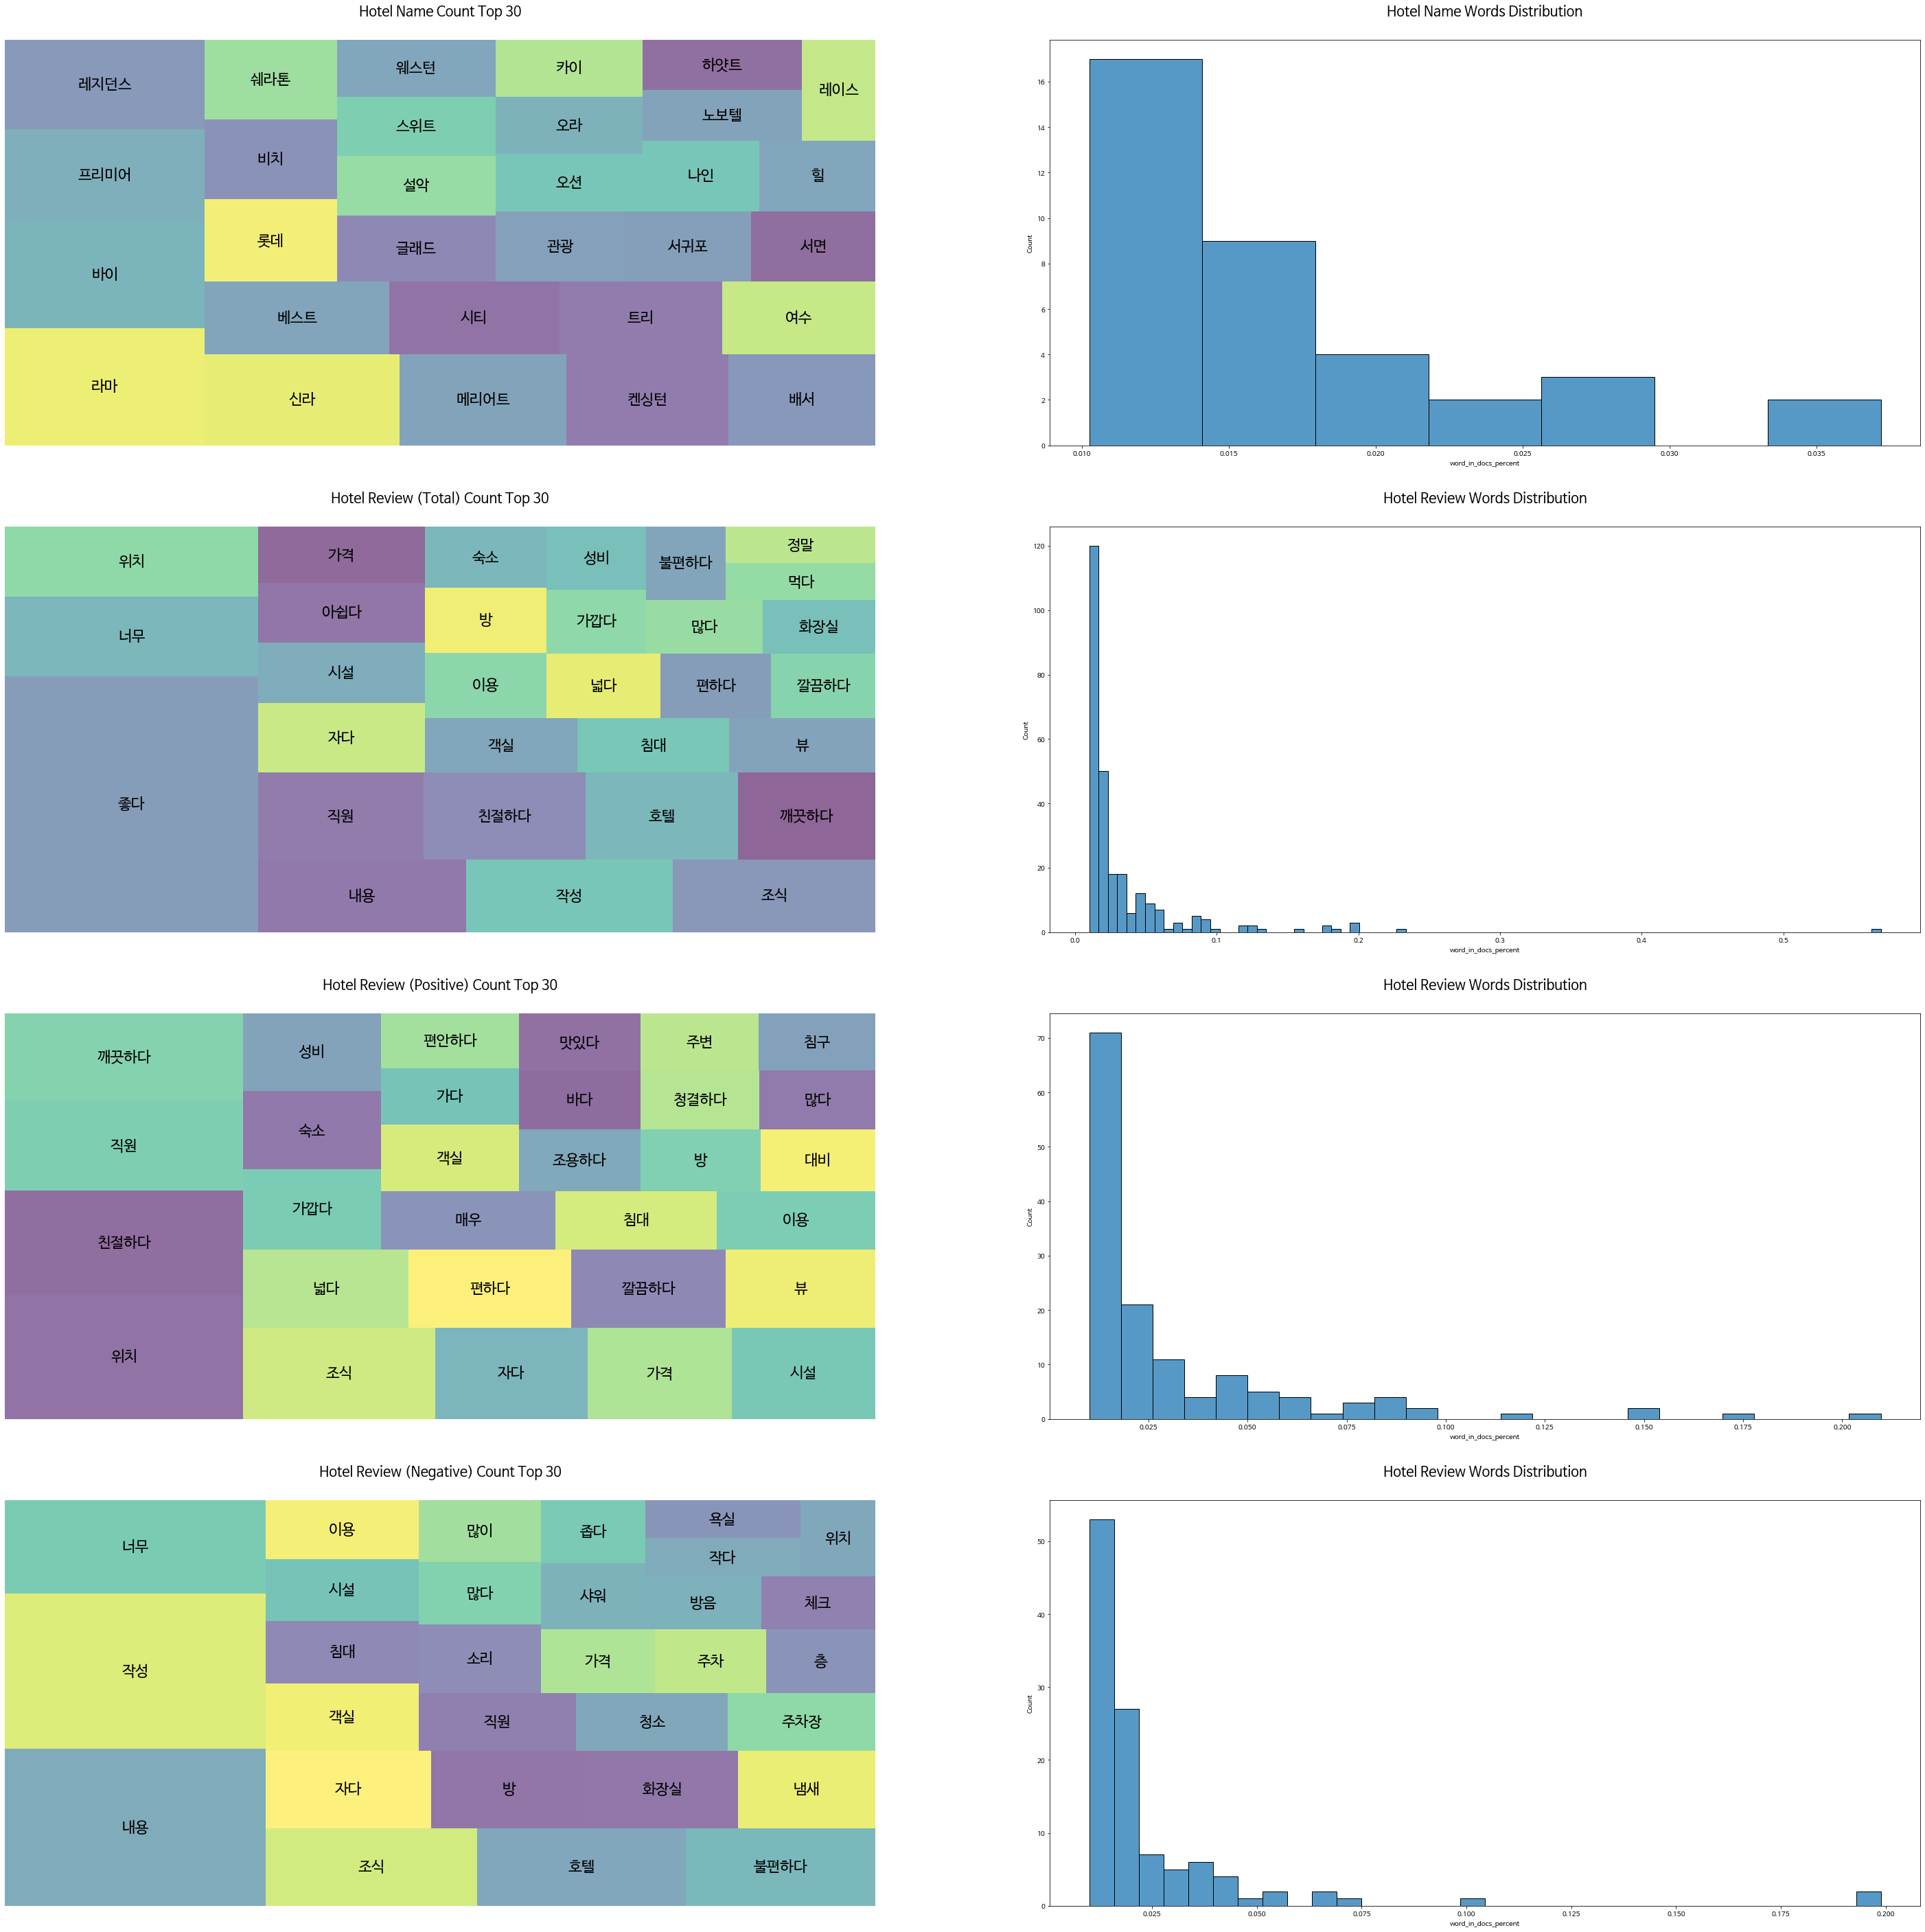

In [ ]:
# 변수 지정
plt.rc('font', family='NanumBarunGothic') 
plt.rc('axes', unicode_minus=False)

wc_1_top20 = wc_1[wc_1['rank'] <= 30]
wc_2_top20 = wc_2[wc_2['rank'] <= 30]
wc_3_top20 = wc_3[wc_3['rank'] <= 30]
wc_4_top20 = wc_4[wc_4['rank'] <= 30]

wc_1_dist = wc_1[wc_1['word_in_docs_percent'] >= 0.01]
wc_2_dist = wc_2[wc_2['word_in_docs_percent'] >= 0.01]
wc_3_dist = wc_3[wc_3['word_in_docs_percent'] >= 0.01]
wc_4_dist = wc_4[wc_4['word_in_docs_percent'] >= 0.01]

# 차트 생성
fig, axes = plt.subplots(4, 2, figsize=(50, 50))
axes[0][0].set_title('Hotel Name Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_1_top20['percent'], label=wc_1_top20['word'], alpha=0.6, ax=axes[0][0], text_kwargs={'fontsize':22})
axes[0][0].axis('off')

axes[0][1].set_title('Hotel Name Words Distribution', size=20, y=1.05)
sns.histplot(wc_1_dist['word_in_docs_percent'], ax=axes[0][1]);

axes[1][0].set_title('Hotel Review (Total) Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_2_top20['percent'], label=wc_2_top20['word'], alpha=0.6, ax=axes[1][0], text_kwargs={'fontsize':22})
axes[1][0].axis('off')

axes[1][1].set_title('Hotel Review Words Distribution', size=20, y=1.05)
sns.histplot(wc_2_dist['word_in_docs_percent'], ax=axes[1][1]);

axes[2][0].set_title('Hotel Review (Positive) Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_3_top20['percent'], label=wc_3_top20['word'], alpha=0.6, ax=axes[2][0], text_kwargs={'fontsize':22})
axes[2][0].axis('off')

axes[2][1].set_title('Hotel Review Words Distribution', size=20, y=1.05)
sns.histplot(wc_3_dist['word_in_docs_percent'], ax=axes[2][1]);

axes[3][0].set_title('Hotel Review (Negative) Count Top 30', size=20, y=1.05)
squarify.plot(sizes=wc_4_top20['percent'], label=wc_4_top20['word'], alpha=0.6, ax=axes[3][0], text_kwargs={'fontsize':22})
axes[3][0].axis('off')

axes[3][1].set_title('Hotel Review Words Distribution', size=20, y=1.05)
sns.histplot(wc_4_dist['word_in_docs_percent'], ax=axes[3][1]);

plt.show();

### **2-4. 데이터 상세 분석**

In [ ]:
# 필요한 데이터 가져오기 -> Positive Review
df_sub_good = df[['hotel_review_good', 'hotel_review_good_token']]

# 필요한 데이터 가져오기 -> Negative Review
df_sub_bad = df[['hotel_review_bad', 'hotel_review_bad_token']]

In [ ]:
# 반복문 설정 -> 리뷰에 특정 키워드가 있으면 가져온다
# Positive 대상 리뷰 추출
review_list_good = []

for i in df['hotel_review_good'] :
  i = str(i)
  if i.find('넓다') != -1 :
    review_list_good.append(i)
  elif i.find('많다') != -1 :
    review_list_good.append(i)
  elif i.find('매우') != -1 :
    review_list_good.append(i)
  else :
    pass

review_list_good[0:10]

['내부 공간이 넓고 고급스러움 부산이지만 여 이로운 분위기가 나는 동네 바닷가가 매우 잘 보임 해외에 놀러 간 기분',
 '청결하고 직원들이 매우 친절',
 '객실이 넓어서 좋았어요 화장실과 샤워실이 별도로 분리되어 있었고 크고 둥근 욕조가 창가 쪽에 배치되어 있어 환상 적임 또한 세면대가 2개였고 파우더 룸이 매우 넓어서 아주 최고였어요 킹 왕짱',
 '잠자리 매우 편해요',
 '침구는 당연히 매우 편안했고 룸이 큰 편이 어 좋았습니다',
 '전망 매우 좋음 한적해서 좋고 아난티 타운이 붙어 있어 편리 수영장과 산책로가 붙어 있어 지나다니는 사람들 마주침 프라이버시 미흡',
 '직원들이 매우 매우 친절 뷔페는 예전보다 맛이 좋아짐',
 '전망이 최고입니다 호텔은 매우 깨끗하고 훌륭합니다 방을 치워주시는 청소해주시는 분께서 정말 친절하셔서 놀랬어요 거실이 넓어서 공간감이 아주 좋았습니다 전체적으로 직원들은 친절했습니다 식사도 정말 맛있었습니다',
 '부모님 보내드렸는데 굉장히 만족스러워하시네요 코로나 때문에 바뀐 조식 운영 방식이 매우 마음에 드셨대요 ㅎㅎ',
 '위치도 좋았고 룸도 매우 만족했습니다']

In [ ]:
# Negative 대상 리뷰 추출
review_list_nega = []

for i in df['hotel_review_bad'] :
  i = str(i)
  if i.find('너무') != -1 :
    review_list_nega.append(i)
  elif i.find('많다') != -1 :
    review_list_nega.append(i)
  elif i.find('많이') != -1 :
    review_list_nega.append(i)
  elif i.find('작다') != -1 :
    review_list_nega.append(i)
  elif i.find('불편하다') != -1 :
    review_list_nega.append(i)
  else :
    pass

review_list_nega[0:10]

['아침식사는 생각만큼 다양한 메뉴로 구성되어 있지는 않았습니다 다른 후기들의 비해 만족스럽지는 않았습니다 너무 큰 기대를 하고 방문을 해서 그런지 다음 방문 시에는 재이용하지 않을 것입니다 가격 대비 만족스럽지 못하였어요',
 '날씨에 영향이 많이 가는 곳이 더군요',
 '객실에서 하수구 냄새가 많이 나서 ㅠㅠ 그거 빼곤 다 만족입니다',
 '가격이 너무 비쌈 외곽에 있어 서울에서 접근하기엔 다소 시간 소요',
 '구성비가 너무 안 좋아요',
 '김해공항에서 호텔까지 교통 편이 불편하다',
 '이그제큐티브 라운지에 사람이 너무 많아서 복잡합니다',
 '조식 너무 비싸요 투숙객한테도 사우나 이용료 받아 요 이 두 가지 얘기하면서 이그제큐티브로 업그레이드하라고 해요',
 '조식을 이용했는데 가격 대비 아주 실망이며 인당 4만 원 정도였는데 너무 비싸고 먹을 건 별로 없음 좋은 점은 바다가 보이는 전망은 아주 좋았음',
 '조식이 비용 대비 많이 부실해서 실망스러웠음']